# Credit Risk

Credit Risk is the possibility of a loss resulting from a borrower's failure to repay a
loan or meet a contractual obligation. The primary goal of a credit risk assessment is to find out whether potential borrowers are creditworthy and have the means to repay their debts so that credit risk or loss can be minimized and the loan is granted to only creditworthy applicants.

If the borrower shows an acceptable level of default risk, then their loan application can be approved upon agreed terms. 

This project involves understanding financial terminologies attached to credit risk and building a classification model for default prediction with Pycaret. Hyperparameter Optimization is done using also the Pycaret library.

# Libraries

In [1]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loadind Data

In [2]:
pwd

'/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction'

In [3]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction/credit_risk_data.csv")
data.head()

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_52028/495261064.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction/credit_risk_data.csv")


,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.0,Female,Yes,4,...,852.69,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.0,Female,No,1,...,4912.53,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.0,Other,NaN,3,...,3310.68,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.0,Male,NaN,1,...,1459.76,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.0,Male,NaN,3,...,1793.00,0,0,0,0,0,0,0,0,202203


In [4]:
cols_old = data.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

data.columns = cols_new

In [5]:
data.columns

Index(['user_id', 'employment_type', 'tier_of_employment', 'industry', 'role',
       'work_experience', 'total_income', 'gender', 'married', 'dependents',
       'home_type', 'pincode', 'has_social_profile', 'is_verified',
       'delinq_2yrs', 'total_payement', 'received_principal',
       'interest_received', 'number_of_loans', 'emi_1_dpd', 'emi_2_dpd',
       'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd',
       'yearmo'],
      dtype='object')

# Duplication Test

Since this analysis should be at user level, would it be affordable to have more rows than userids? 

In [6]:
data["user_id"].nunique()

133752

In [7]:
data.shape[0]

143727

Notice below that some users appears more than once. Some of them appears 16 times. Let's check it out. 

In [8]:
data["user_id"].value_counts()

3166625     16
2803481     16
2789468     16
3440082     16
3062454     16
            ..
2814679      1
2819122      1
2818821      1
2819179      1
56122051     1
Name: user_id, Length: 133752, dtype: int64

In [9]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
36527,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,3,...,3355.56,0,90,90,90,90,90,90,90,202201
36528,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,3,...,550.89,0,0,0,0,0,0,0,0,202203
36529,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,2,...,3355.56,0,90,90,90,90,90,90,90,202203
36530,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,2,...,550.89,0,0,0,0,0,0,0,0,202203
36531,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.0,Female,Yes,3,...,3355.56,0,90,90,90,90,90,90,90,202205
36532,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.0,Female,Yes,3,...,550.89,0,0,0,0,0,0,0,0,202205
36533,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.0,Female,Yes,2,...,3355.56,0,90,90,90,90,90,90,90,202202
36534,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.0,Female,Yes,2,...,550.89,0,0,0,0,0,0,0,0,202205
36535,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,3,...,3355.56,0,0,90,90,90,90,90,90,202201
36536,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,3,...,550.89,0,0,0,0,0,0,0,0,202205


In [10]:
data.iloc[:, 0:15]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,home_type,pincode,has_social_profile,is_verified,delinq_2yrs
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.0,Female,Yes,4,rent,XX852X,No,NaN,0
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.0,Female,No,1,mortgage,XX286X,NaN,Source Verified,0
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.0,Other,NaN,3,own,XX113X,No,NaN,0
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.0,Male,NaN,1,rent,XX941X,Yes,NaN,0
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.0,Male,NaN,3,rent,XX913X,No,Verified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143722,55993166,NaN,NaN,0,KHMbckjadbckIFGTNSEWdkcndwkcnCCM,0,100000.0,Female,No,2,mortgage,XX374X,NaN,Source Verified,1
143723,56263229,NaN,NaN,0,KHMbckjadbckIFGOHSEWdkcndwkcnCCM,0,27000.0,Male,Yes,3,rent,XX436X,No,Source Verified,0
143724,55992716,NaN,NaN,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,53000.0,Female,Yes,2,rent,XX908X,NaN,NaN,0
143725,56363313,NaN,NaN,0,KHMbckjadbckIFGVASEWdkcndwkcnCCM,0,75400.0,Other,No,0,mortgage,XX229X,NaN,Source Verified,0


In [11]:
data.iloc[:, 15:30]

,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,1824.150000,971.46,852.69,0,0,90,90,90,90,90,90,202203
1,22912.532998,18000.00,4912.53,0,0,0,0,0,0,0,0,202203
2,7800.440000,4489.76,3310.68,0,90,90,90,90,90,90,90,202205
3,6672.050000,5212.29,1459.76,0,0,0,0,0,0,0,0,202203
4,11793.001345,10000.00,1793.00,0,0,0,0,0,0,0,0,202203
...,...,...,...,...,...,...,...,...,...,...,...,...
143722,12842.400000,7193.83,5648.57,0,0,0,0,30,0,0,30,202205
143723,839.200000,581.67,257.53,0,0,0,0,0,0,0,0,202203
143724,6085.800000,2434.49,3651.31,0,0,0,0,0,0,0,0,202204
143725,4080.640000,3286.82,793.82,0,0,0,0,0,0,30,30,202202


# Deduplication

Let's consider for deduplication:

1. The most recent updated date in our dataset for every user.
2. The smallest total income. 

In [12]:
# sort the dataframe by 'yearmo' in descending order
data.sort_values(by=['yearmo', 'total_income'], ascending=[False, True], inplace=True)

# drop duplicates based on 'user_id' while keeping the first occurence (maximum 'yearmo')
data = data.drop_duplicates(subset='user_id', keep='first')

# reset the index of the new dataframe
data.reset_index(drop=True, inplace=True)

In [13]:
data["user_id"].nunique()

133752

In [14]:
data.shape[0]

133752

In [15]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
6922,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.0,Female,Yes,3,...,550.89,0,0,0,0,0,0,0,0,202205


# Helper Functions

In [16]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
   
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
   
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 1. Data Description

In [17]:
df1 = data.copy()

## 1.1. Data Dimensions

In [18]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 133752
Number of cols: 27


## 1.2. Data Types

In [19]:
df1.dtypes

user_id                 int64
employment_type        object
tier_of_employment     object
industry               object
role                   object
work_experience        object
total_income          float64
gender                 object
married                object
dependents              int64
home_type              object
pincode                object
has_social_profile     object
is_verified            object
delinq_2yrs             int64
total_payement        float64
received_principal    float64
interest_received     float64
number_of_loans         int64
emi_1_dpd               int64
emi_2_dpd               int64
emi_3_dpd               int64
emi_4_dpd               int64
emi_5_dpd               int64
emi_6_dpd               int64
max_dpd                 int64
yearmo                  int64
dtype: object

# 1.3. Data Conversion

In [21]:
df1['yearmo'] = df1['yearmo'].astype(str)  # Garante que 'yearmo' seja uma string
df1['yearmo'] = df1['yearmo'].apply(lambda x: f"{x[:4]}-{x[4:]}")
df1['yearmo'] = pd.to_datetime(df1['yearmo'], format='%Y-%m')

In [24]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

## 1.4. Na Check

In [25]:
df1.isna().sum()

user_id                   0
employment_type       79334
tier_of_employment    79334
industry                  4
role                      0
work_experience           4
total_income              0
gender                    0
married               44856
dependents                0
home_type                 0
pincode                   0
has_social_profile    44627
is_verified           33358
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
emi_1_dpd                 0
emi_2_dpd                 0
emi_3_dpd                 0
emi_4_dpd                 0
emi_5_dpd                 0
emi_6_dpd                 0
max_dpd                   0
yearmo                    0
dtype: int64

In [27]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1.isna().sum()/len(df1)

user_id              0.00
employment_type      0.59
tier_of_employment   0.59
industry             0.00
role                 0.00
work_experience      0.00
total_income         0.00
gender               0.00
married              0.34
dependents           0.00
home_type            0.00
pincode              0.00
has_social_profile   0.33
is_verified          0.25
delinq_2yrs          0.00
total_payement       0.00
received_principal   0.00
interest_received    0.00
number_of_loans      0.00
emi_1_dpd            0.00
emi_2_dpd            0.00
emi_3_dpd            0.00
emi_4_dpd            0.00
emi_5_dpd            0.00
emi_6_dpd            0.00
max_dpd              0.00
yearmo               0.00
dtype: float64

In [28]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

In [29]:
df1["employment_type"] = df1["employment_type"].fillna("SI")

df1["tier_of_employment"] = df1["tier_of_employment"].fillna("SI")

df1["industry"] = df1["industry"].fillna("SI")

df1["work_experience"] = df1["work_experience"].fillna("SI")

df1["married"] = df1["married"].fillna("SI")

df1["has_social_profile"] = df1["has_social_profile"].fillna("SI")

df1["is_verified"] = df1["is_verified"].fillna("SI")

In [30]:
df1.isna().sum()

user_id               0
employment_type       0
tier_of_employment    0
industry              0
role                  0
work_experience       0
total_income          0
gender                0
married               0
dependents            0
home_type             0
pincode               0
has_social_profile    0
is_verified           0
delinq_2yrs           0
total_payement        0
received_principal    0
interest_received     0
number_of_loans       0
emi_1_dpd             0
emi_2_dpd             0
emi_3_dpd             0
emi_4_dpd             0
emi_5_dpd             0
emi_6_dpd             0
max_dpd               0
yearmo                0
dtype: int64

## 1.6. Descriptive Statistics

In [33]:
num_attributes = df1.drop(columns=["user_id"]).select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.6.1. Numerical Attributes

In [34]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,total_income,4000.000,7141778.000,7137778.000,72538.108,62000.000,56122.189,28.837,2791.391
1,dependents,0.000,4.000,4.000,2.002,2.000,1.414,-0.005,-1.300
2,delinq_2yrs,0.000,22.000,22.000,0.284,0.000,0.800,5.421,52.951
3,total_payement,0.000,57777.580,57777.580,10686.194,8046.045,8541.111,1.603,2.748
4,received_principal,0.000,35000.010,35000.010,8273.808,5860.050,7183.243,1.559,2.327
5,interest_received,0.000,24205.620,24205.620,2334.677,1626.310,2416.865,2.848,11.644
6,number_of_loans,0.000,5.000,5.000,0.006,0.000,0.099,22.902,635.940
7,emi_1_dpd,0.000,90.000,90.000,7.700,0.000,23.763,3.023,7.501
8,emi_2_dpd,0.000,90.000,90.000,8.301,0.000,24.595,2.842,6.405
9,emi_3_dpd,0.000,90.000,90.000,8.325,0.000,24.744,2.866,6.519


- The maximum value of DPD is 90 days.
- It seems the majority of users have lower total income, since we found a high standard deviation and positive skew.

### Total income

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


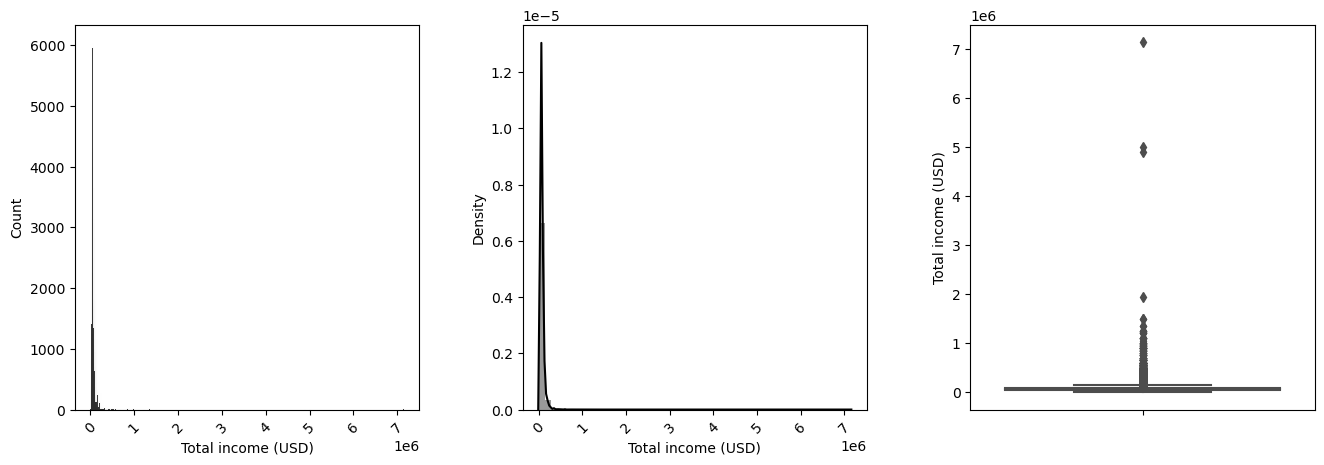

In [36]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


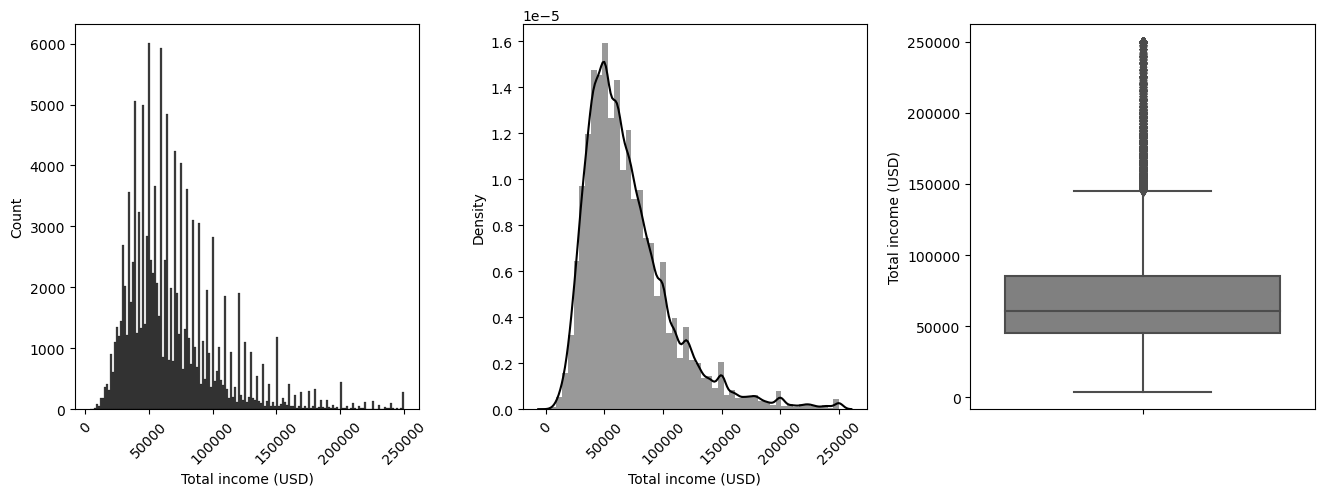

In [43]:
aux = num_attributes.copy()
aux = aux[aux["total_income"] <= 250000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

In [44]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["total_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_income,132675.00,69857.66,36860.45,4000.00,45000.00,61000.00,85000.00,250000.00


- Since we have high value for skew and a high value for kurtosis, we may assume there are outliers for total income.
- Therefore, median is more representative than mean.
- Median is around 61000 USD. 
- A value lower than 250000 USD should be used as upper limit to remove outliers.